# Visualizations of time-series data

### Import Libraries

In [2]:
%%time
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go 
from plotly.graph_objects import Layout
#import dataframe_image as dfi #Optional for saving df as picture
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import numpy as np
from sklearn import preprocessing
import matplotlib as mpl
scaler = preprocessing.MinMaxScaler()
df_raw = pd.read_excel(open('..dataset/crude_oil_price_and_sentiment_cogn2022.xlsx', 'rb'), sheet_name='Raw', engine='openpyxl')
df_normalized = pd.read_excel(open('../dataset/crude_oil_price_and_sentiment_cogn2022.xlsx', 'rb'), sheet_name='Normalized', engine='openpyxl')  

FileNotFoundError: [Errno 2] No such file or directory: '/dataset/crude_oil_price_and_sentiment_cogn2022.xlsx'

### Select time window of the dataset (range: 01.2012 - 04.2021)

In [2]:
dataset_all = df_normalized # select between df_raw and df_normalized
start_date = '01-01-2012'
end_date = '04-01-2021'
selected_date = (dataset_all['Date'] >= start_date) & (dataset_all['Date'] <= end_date)
dataset = dataset_all.loc[selected_date]
dataset.head()

,Unnamed: 0,Date,Price_change_normalized,Price_normalized,Daily_Sum_RavenPack_normalized,Csum_RavenPack_normalized,Daily_Sum_FinBERT_normalized,Csum_FinBERT_normalized,Daily_Sum_CrudeBERT_normalized,Csum_CrudeBERT_normalized,Daily_Sum_CrudeBERT_GT_normalized,Csum_CrudeBERT_GT_normalized,Daily_Sum_CrudeBERT_Plus_normalized,Csum_CrudeBERT_Plus_normalized,Daily_Sum_CrudeBERT_Plus_GT_normalized,Csum_CrudeBERT_Plus_GT_normalized
0,1,2012-01-01,NaN,NaN,0.290618,-0.881584,-0.076923,0.996476,0.224665,0.214182,0.137787,0.520282,0.040244,0.993878,0.020886,0.997670
1,2,2012-01-02,NaN,NaN,0.409611,-0.872358,-0.230769,0.995154,0.579376,0.241237,0.418438,0.539966,0.115556,0.997416,0.074770,0.999603
2,3,2012-01-03,NaN,0.849383,0.144165,-0.869012,0.384615,0.995595,0.090034,0.245914,0.102908,0.544678,-0.239179,0.987955,-0.233376,0.992445
3,4,2012-01-04,-0.120777,0.854556,-0.034325,-0.869620,0.692308,0.996916,-0.181912,0.238154,-0.165684,0.536643,0.011107,0.987665,0.001614,0.992220
4,5,2012-01-05,-0.246543,0.826502,0.217391,-0.864653,0.846154,0.998678,-0.133834,0.232592,-0.124270,0.530573,0.003259,0.987088,-0.006788,0.991747


### Plot Comparison WTI Crude Oil Price and different Cumulative Sentiment Scores (scaled)

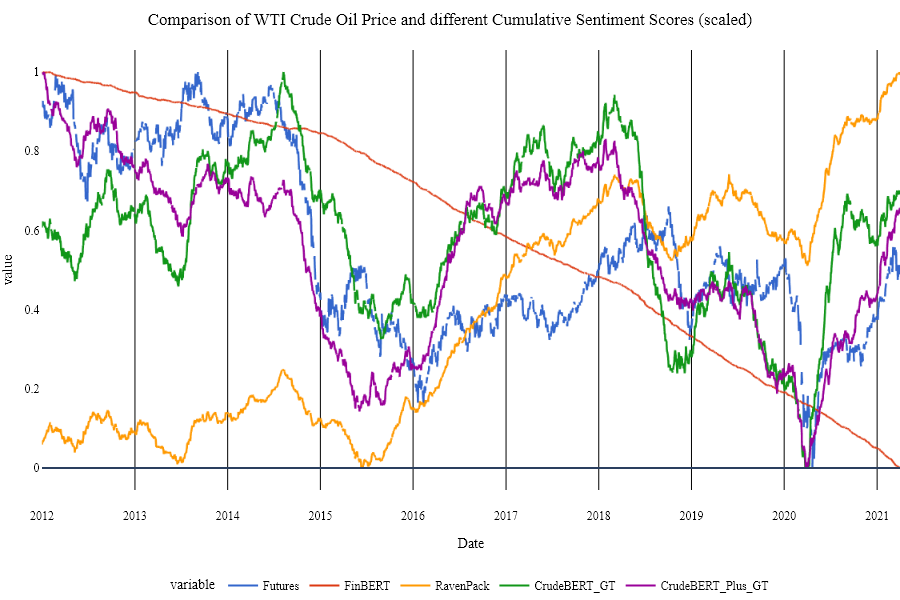

In [3]:
start_date = '01-01-2012'
end_date = '04-01-2021'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]


dataset_date = dataset_date.loc[selected_date]

dataset_date["Futures"] = dataset_date["Price_normalized"]
dataset_date["FinBERT"]= dataset_date["Csum_FinBERT_normalized"]
dataset_date["RavenPack"] = dataset_date["Csum_RavenPack_normalized"]
dataset_date["CrudeBERT_GT"] = dataset_date["Csum_CrudeBERT_normalized"]
dataset_date["CrudeBERT_Plus_GT"] = dataset_date["Csum_CrudeBERT_Plus_normalized"]


selected_data=['Futures',
               'FinBERT',
               'RavenPack',
               'CrudeBERT_GT',
               'CrudeBERT_Plus_GT']


dataset_plot = dataset_date.copy()
dataset_plot[selected_data] = scaler.fit_transform(dataset_plot[selected_data]) # scaling selected data (optional)

fig = px.line(dataset_plot, x="Date", y=selected_data,
              hover_data={"Date": "|%B %d, %Y"},
              color_discrete_sequence=px.colors.qualitative.G10,
              title='Comparison of WTI Crude Oil Price and different Cumulative Sentiment Scores (scaled)')

fig.update_xaxes(
    dtick="",
    tickformat="\n%Y",
    showgrid = True,
    gridcolor='black',
    linewidth = 0.01)

fig.update_yaxes(
    dtick="",
    tickformat="\n%Y",
    showgrid = False,
    gridcolor='black',
    linewidth = 0.1)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-0.25,
    xanchor="center",
    x=0.5))

fig.add_hline(y=0)

fig.update_layout(
    font_family="Times New Roman",
    font_color="black",
    title_font_family="Times New Roman",
    title_font_color="black",
    legend_title_font_color="black")




fig['layout'].update(width=900, height=600, autosize=False)
fig.update_layout(margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(plot_bgcolor="white",title_x=0.5)
#fig.show("notebook")
#fig.write_image("comparison_cumulative_values_cb_plus_gt_new.pdf")
fig.show("png")

### Yearly DTW distance between oil prices and cumulative sentiment scores of different classifiers

In [4]:
Price = "Price_normalized"
RavenPack = "Csum_RavenPack_normalized"
FinBERT = "Csum_FinBERT_normalized"
CrudeBERT = "Csum_CrudeBERT_normalized"
CrudeBERT_GT = "Csum_CrudeBERT_GT_normalized"
CrudeBERT_Plus = "Csum_CrudeBERT_Plus_normalized"
CrudeBERT_Plus_GT = "Csum_CrudeBERT_Plus_GT_normalized"

selected_data = ['Date', Price, RavenPack, FinBERT, CrudeBERT, CrudeBERT_GT, CrudeBERT_Plus, CrudeBERT_Plus_GT]


dataset_interpolate = dataset_all[selected_data].select_dtypes(exclude='datetime64[ns]').interpolate(method="linear")
dataset_interpolate = dataset_interpolate.dropna()
dataset_interpolate["Date"] = dataset_all["Date"] #Filling in NaN in a Series via linear interpolation

dataset_propagate = dataset_all[selected_data].fillna(method="ffill")
dataset_propagate = dataset_propagate.dropna() #Propagates NaN-values forward or backward

dataset_drop = dataset_all[selected_data].dropna() #NaN-values are dropped

dataset = dataset_propagate

average_price = dataset[Price].mean()
dataset[Price] = dataset.apply(lambda row: row[Price] - average_price, axis=1)

start_date = '01-01-2012'
end_date = '04-01-2021'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

name_of_df = 'DTW-Distance to Price'
df_dtw = pd.DataFrame(data={name_of_df: ['RavenPack', 'FinBERT', 'CrudeBERT', 'CrudeBERT_GT', 'CrudeBERT_Plus', 'CrudeBERT_Plus_GT'],
                             '01-01-2012': [0,0,0,0,0,0],'01-01-2013': [0,0,0,0,0,0],'01-01-2014': [0,0,0,0,0,0],
                             '01-01-2015': [0,0,0,0,0,0],'01-01-2016': [0,0,0,0,0,0],'01-01-2017': [0,0,0,0,0,0], 
                             '01-01-2018': [0,0,0,0,0,0],'01-01-2019': [0,0,0,0,0,0],'01-01-2020': [0,0,0,0,0,0]})

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2012'
end_date = '01-01-2013'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2013'
end_date = '01-01-2014'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2014'
end_date = '01-01-2015'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2015'
end_date = '01-01-2016'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2016'
end_date = '01-01-2017'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2017'
end_date = '01-01-2018'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2018'
end_date = '01-01-2019'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2019'
end_date = '01-01-2020'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2020'
end_date = '01-01-2021'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

#df_corr = df_corr.set_index('Labels')
df_dtw_picture = df_dtw.style.background_gradient(cmap='RdYlGn_r',axis=0)
#dfi.export(df_dtw_picture,'../results/'+name_of_df+'.png')
df_dtw_picture

,DTW-Distance to Price,01-01-2012,01-01-2013,01-01-2014,01-01-2015,01-01-2016,01-01-2017,01-01-2018,01-01-2019,01-01-2020
0,RavenPack,506,541,442,188,18,162,103,171,360
1,FinBERT,137,70,72,330,270,126,31,118,110
2,CrudeBERT,114,111,32,108,199,311,135,40,133
3,CrudeBERT_GT,34,79,23,79,28,164,54,79,47
4,CrudeBERT_Plus,34,80,79,34,148,273,92,42,41
5,CrudeBERT_Plus_GT,47,59,67,103,57,136,29,46,39


### Continuous DTW distance between oil prices and cumulative sentiment scores of different classifiers

In [5]:
Price = "Price_normalized"
RavenPack = "Csum_RavenPack_normalized"
FinBERT = "Csum_FinBERT_normalized"
CrudeBERT = "Csum_CrudeBERT_normalized"
CrudeBERT_GT = "Csum_CrudeBERT_GT_normalized"
CrudeBERT_Plus = "Csum_CrudeBERT_Plus_normalized"
CrudeBERT_Plus_GT = "Csum_CrudeBERT_Plus_GT_normalized"

selected_data = ['Date', Price, RavenPack, FinBERT, CrudeBERT, CrudeBERT_GT, CrudeBERT_Plus, CrudeBERT_Plus_GT]


dataset_interpolate = dataset_all[selected_data].select_dtypes(exclude='datetime64[ns]').interpolate(method="linear")
dataset_interpolate = dataset_interpolate.dropna()
dataset_interpolate["Date"] = dataset_all["Date"] #Filling in NaN in a Series via linear interpolation

dataset_propagate = dataset_all[selected_data].fillna(method="ffill")
dataset_propagate = dataset_propagate.dropna() #Propagates NaN-values forward or backward

dataset_drop = dataset_all[selected_data].dropna() #NaN-values are dropped

dataset = dataset_propagate

average_price = dataset[Price].mean()
dataset[Price] = dataset.apply(lambda row: row[Price] - average_price, axis=1)

start_date = '01-01-2012'
end_date = '04-01-2021'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

name_of_df = 'DTW-Distance to Price'
df_dtw = pd.DataFrame(data={name_of_df: ['RavenPack', 'FinBERT', 'CrudeBERT', 'CrudeBERT_GT', 'CrudeBERT_Plus', 'CrudeBERT_Plus_GT'],
                             '01-01-2012': [0,0,0,0,0,0],'01-01-2013': [0,0,0,0,0,0],'01-01-2014': [0,0,0,0,0,0],
                             '01-01-2015': [0,0,0,0,0,0],'01-01-2016': [0,0,0,0,0,0],'01-01-2017': [0,0,0,0,0,0], 
                             '01-01-2018': [0,0,0,0,0,0],'01-01-2019': [0,0,0,0,0,0],'01-01-2020': [0,0,0,0,0,0]})

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2013'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2014'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2015'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2016'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2017'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2018'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2019'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2020'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

#df_corr = df_corr.set_index('Labels')
df_dtw_picture = df_dtw.style.background_gradient(cmap='RdYlGn_r',axis=0)
#dfi.export(df_dtw_picture,'../results/'+name_of_df+'.png')
df_dtw_picture

,DTW-Distance to Price,01-01-2012,01-01-2013,01-01-2014,01-01-2015,01-01-2016,01-01-2017,01-01-2018,01-01-2019,01-01-2020
0,RavenPack,2258,1754,1214,885,697,763,687,626,455
1,FinBERT,598,553,468,960,625,347,232,244,182
2,CrudeBERT,635,665,448,468,441,536,224,89,94
3,CrudeBERT_GT,293,237,153,171,136,194,99,47,57
4,CrudeBERT_Plus,438,376,363,254,239,405,133,41,41
5,CrudeBERT_Plus_GT,279,234,202,147,93,197,77,45,40


### Yearly DTW distance between oil price changes and sentiment scores of different classifiers

In [6]:
Price = "Price_change_normalized"
RavenPack = "Daily_Sum_RavenPack_normalized"
FinBERT = "Daily_Sum_FinBERT_normalized"
CrudeBERT = "Daily_Sum_CrudeBERT_normalized"
CrudeBERT_GT = "Daily_Sum_CrudeBERT_GT_normalized"
CrudeBERT_Plus = "Daily_Sum_CrudeBERT_Plus_normalized"
CrudeBERT_Plus_GT = "Daily_Sum_CrudeBERT_Plus_GT_normalized"

selected_data = ['Date', Price, RavenPack, FinBERT, CrudeBERT, CrudeBERT_GT, CrudeBERT_Plus, CrudeBERT_Plus_GT]

dataset_interpolate = dataset_all[selected_data].select_dtypes(exclude='datetime64[ns]').interpolate(method="linear")
dataset_interpolate = dataset_interpolate.dropna()
dataset_interpolate["Date"] = dataset_all["Date"] #Filling in NaN in a Series via linear interpolation

dataset_propagate = dataset_all[selected_data].fillna(method="ffill")
dataset_propagate = dataset_propagate.dropna() #Propagates NaN-values forward or backward

dataset_drop = dataset_all[selected_data].dropna() #NaN-values are dropped

dataset = dataset_drop

average_price = dataset[Price].mean()
dataset[Price] = dataset.apply(lambda row: row[Price] - average_price, axis=1)

start_date = '01-01-2012'
end_date = '04-01-2021'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

name_of_df = 'DTW-Distance to Price Change'
df_dtw = pd.DataFrame(data={name_of_df: ['RavenPack', 'FinBERT', 'CrudeBERT', 'CrudeBERT_GT', 'CrudeBERT_Plus', 'CrudeBERT_Plus_GT'],
                             '01-01-2012': [0,0,0,0,0,0],'01-01-2013': [0,0,0,0,0,0],'01-01-2014': [0,0,0,0,0,0],
                             '01-01-2015': [0,0,0,0,0,0],'01-01-2016': [0,0,0,0,0,0],'01-01-2017': [0,0,0,0,0,0], 
                             '01-01-2018': [0,0,0,0,0,0],'01-01-2019': [0,0,0,0,0,0],'01-01-2020': [0,0,0,0,0,0]})

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2012'
end_date = '01-01-2013'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2013'
end_date = '01-01-2014'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2014'
end_date = '01-01-2015'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2015'
end_date = '01-01-2016'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2016'
end_date = '01-01-2017'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2017'
end_date = '01-01-2018'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2018'
end_date = '01-01-2019'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2019'
end_date = '01-01-2020'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2020'
end_date = '01-01-2021'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

#df_corr = df_corr.set_index('Labels')
df_dtw_picture = df_dtw.style.background_gradient(cmap='RdYlGn_r',axis=0)
#dfi.export(df_dtw_picture,'../results/'+name_of_df+'.png')
df_dtw_picture

,DTW-Distance to Price Change,01-01-2012,01-01-2013,01-01-2014,01-01-2015,01-01-2016,01-01-2017,01-01-2018,01-01-2019,01-01-2020
0,RavenPack,81,68,56,65,72,61,83,77,69
1,FinBERT,94,95,85,69,87,76,97,87,91
2,CrudeBERT,74,66,59,59,59,60,93,78,75
3,CrudeBERT_GT,68,83,67,79,75,44,54,48,50
4,CrudeBERT_Plus,71,65,64,63,62,72,80,72,68
5,CrudeBERT_Plus_GT,58,77,71,77,76,48,56,48,46


### Continuous DTW distance between oil price changes and sentiment scores of different classifiers

In [7]:
Price = "Price_change_normalized"
RavenPack = "Daily_Sum_RavenPack_normalized"
FinBERT = "Daily_Sum_FinBERT_normalized"
CrudeBERT = "Daily_Sum_CrudeBERT_normalized"
CrudeBERT_GT = "Daily_Sum_CrudeBERT_GT_normalized"
CrudeBERT_Plus = "Daily_Sum_CrudeBERT_Plus_normalized"
CrudeBERT_Plus_GT = "Daily_Sum_CrudeBERT_Plus_GT_normalized"
selected_data = ['Date', Price, RavenPack, FinBERT, CrudeBERT, CrudeBERT_GT, CrudeBERT_Plus, CrudeBERT_Plus_GT]


dataset_interpolate = dataset_all[selected_data].select_dtypes(exclude='datetime64[ns]').interpolate(method="linear")
dataset_interpolate = dataset_interpolate.dropna()
dataset_interpolate["Date"] = dataset_all["Date"] #Filling in NaN in a Series via linear interpolation

dataset_propagate = dataset_all[selected_data].fillna(method="ffill")
dataset_propagate = dataset_propagate.dropna() #Propagates NaN-values forward or backward

dataset_drop = dataset_all[selected_data].dropna() #NaN-values are dropped

dataset = dataset_interpolate

average_price = dataset[Price].mean()
dataset[Price] = dataset.apply(lambda row: row[Price] - average_price, axis=1)

start_date = '01-01-2012'
end_date = '04-01-2021'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

name_of_df = 'DTW-Distance to Price Change'
df_dtw = pd.DataFrame(data={name_of_df: ['RavenPack', 'FinBERT', 'CrudeBERT', 'CrudeBERT_GT', 'CrudeBERT_Plus', 'CrudeBERT_Plus_GT'],
                             '01-01-2012': [0,0,0,0,0,0],'01-01-2013': [0,0,0,0,0,0],'01-01-2014': [0,0,0,0,0,0],
                             '01-01-2015': [0,0,0,0,0,0],'01-01-2016': [0,0,0,0,0,0],'01-01-2017': [0,0,0,0,0,0], 
                             '01-01-2018': [0,0,0,0,0,0],'01-01-2019': [0,0,0,0,0,0],'01-01-2020': [0,0,0,0,0,0]})

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2013'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2014'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2015'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2016'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2017'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2018'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2019'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

start_date = '01-01-2020'
dataset_date = dataset.copy()
selected_date = (dataset_date['Date'] >= start_date) & (dataset_date['Date'] <= end_date)
dataset_date = dataset_date.loc[selected_date]
dataset_dtw = dataset_date

Price_dtw = dataset_dtw[Price]
RavenPack_dtw = dataset_dtw[RavenPack]
FinBERT_dtw = dataset_dtw[FinBERT]
CrudeBERT_dtw = dataset_dtw[CrudeBERT]
CrudeBERT_GT_dtw = dataset_dtw[CrudeBERT_GT]
CrudeBERT_Plus_dtw = dataset_dtw[CrudeBERT_Plus]
CrudeBERT_Plus_GT_dtw = dataset_dtw[CrudeBERT_Plus_GT]
dtw_distance_RP, warp_path = fastdtw(Price_dtw, RavenPack_dtw, dist=euclidean)
dtw_distance_FB, warp_path = fastdtw(Price_dtw, FinBERT_dtw, dist=euclidean)
dtw_distance_CB, warp_path = fastdtw(Price_dtw, CrudeBERT_dtw, dist=euclidean)
dtw_distance_CB_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_GT_dtw, dist=euclidean)
dtw_distance_CB_Plus, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_dtw, dist=euclidean)
dtw_distance_CB_Plus_GT, warp_path = fastdtw(Price_dtw, CrudeBERT_Plus_GT_dtw, dist=euclidean)
df_dtw.loc[[0],str(start_date)] = round(dtw_distance_RP, 0)
df_dtw.loc[[1],str(start_date)] = round(dtw_distance_FB, 0)
df_dtw.loc[[2],str(start_date)] = round(dtw_distance_CB, 0)
df_dtw.loc[[3],str(start_date)] = round(dtw_distance_CB_GT, 0)
df_dtw.loc[[4],str(start_date)] = round(dtw_distance_CB_Plus, 0)
df_dtw.loc[[5],str(start_date)] = round(dtw_distance_CB_Plus_GT, 0)

#df_corr = df_corr.set_index('Labels')
df_dtw_picture = df_dtw.style.background_gradient(cmap='RdYlGn_r',axis=0)
#dfi.export(df_dtw_picture,'../results/'+name_of_df+'.png')
df_dtw_picture

,DTW-Distance to Price Change,01-01-2012,01-01-2013,01-01-2014,01-01-2015,01-01-2016,01-01-2017,01-01-2018,01-01-2019,01-01-2020
0,RavenPack,760,663,617,520,461,346,285,192,98
1,FinBERT,907,868,735,598,481,410,330,222,128
2,CrudeBERT,721,631,572,513,424,352,285,196,104
3,CrudeBERT_GT,626,591,503,423,316,230,184,126,67
4,CrudeBERT_Plus,695,643,591,486,421,330,260,180,100
5,CrudeBERT_Plus_GT,622,545,485,416,303,222,167,119,70
